In [140]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
plt.rcParams["figure.figsize"] = (16,9)


In this project, we are solving the following partial differential equation representing the black scholes equation for two derivative products: a call spread and a put option

$$ \frac{\partial V(t,s)}{\partial t} + r\,s \frac{\partial V(t,s)}{\partial s} + \frac{1}{2} \sigma^2 s^2 \frac{\partial^2  V(t,s)}{\partial s^2} - r  V(t,s)  = 0. $$

Two methods are implemented in solving the PDE: the implicit finite differentiation method and crank-nicholson method.
Alongside, since the Black scholes equation can be solved directly for a single call and a put, the formula for black scholes is alos implemented for comparision. 

In [141]:
def BS_formula_call(S_0, K, r, sigma, T):
    d_1 = (np.log(S_0/K) + (r + sigma**2/2) * T)/(sigma * np.sqrt(T))
    d_2 = d_1 - sigma * np.sqrt(T)
    return S_0 * norm.cdf(d_1) - K * np.exp(-r*T) * norm.cdf(d_2)
    

The implicit differentiation method and crank-nicholson method for pricing a call are shown in the cells below. The code for the implicit method was obtained from the excercise practised in class. In this method, the future prices of the underlying asset is approximated using a forward approximation method as discussed in class. The development of the crank-nicholson method is discussed in the cell below. 

To price the call spread, one can either specify the boundary conditions related to the call spread directly or individually price the long legs and the short legs and subtract the short leg from the long leg. In implicit method, the latter method for pricing the spread is used while in the crank nicholson method the former method for boundary conditions is used.


For an option with strike $K$ and maturity $T$, the boundary conditions are :

Terminal: $    V(T,x) = max(e^x-K,0) $
         
Lateral: $  V(t, x) \underset{x \to -\infty}{=} 0 \quad \mbox{and} \quad V(t, x) \underset{x \to \infty}{\sim} e^x - Ke^{-r(T-t)}. $

Here, instead of considering that x goes to infinity, H is defined sufficiently large such that the bounds for the dx variation is [log(S0) − H ,log(S0) + H] Here, the idea is that we want the upper bound of this is interval high enough so that it is unlikely for the underlying price to reach that level in the given maturity time frame. 



In [142]:
def pde_scheme_implicit_call(S_0, r, sigma, T, K, H, nb_x_side, nb_t):
    nb_x = 2 * nb_x_side + 1
    xs = np.linspace(np.log(S_0)-H, np.log(S_0)+H, nb_x)
    dx = 2. * H / (nb_x - 1.) 
    dt = T / (nb_t - 1.)
    ts = np.linspace(0, T, nb_t)
    p = np.empty([nb_x, nb_t])
    g = lambda S : np.maximum(S-K,0.)
    p[:,0] = g(np.exp(xs)) 
    p[0,:] = 0.
    p[-1,:] = np.exp(np.log(S_0)+H) - K * np.exp(-r*ts)
    d = 1.+dt*(r + (r-0.5*sigma**2)/dx + sigma**2 / dx**2)
    sup_d = -dt*((r-0.5*sigma**2)/dx + 0.5 * sigma**2 / dx**2)
    inf_d = -dt*(0.5 * sigma**2 / dx**2)
    A = np.diag(d * np.ones(nb_x-2)) + np.diag(sup_d * np.ones(nb_x-3), 1) + np.diag(inf_d * np.ones(nb_x-3), -1)
    v = np.zeros_like(p[1:-1,0])
    v[-1] = 1.
    invA = np.linalg.inv(A)
    for t in range(1,nb_t):
        p[1:-1,t] = invA @ (p[1:-1,t-1] - sup_d * p[-1,t] * v)   
    return p,p[nb_x_side,-1]


To design the crank nicholson scheme following paper was reviewed and implemented along with the excercise done in class: https://www.ijsrp.org/research-paper-1119/ijsrp-p9575.pdf page(10/14)

Here, the crank nicholson method is the average of the explicit and the implicit method. It uses central differentiation method for $\frac{\partial^2  V(t,s)}{\partial s^2}$. 
The idea for implementing this method is that the future values of the underlying depends on the present value of the underlying prices in the time and asset mesh which can be represented in the matrix notation as follows: 

$$A ∗ V(j+1)+ b = B ∗ V(j) +c$$

$$V(j+1) = A^{-1}∗ (B ∗ V(j) + 𝒄 − b)$$

where, the matrices A, B, c and b obtained as shown in the paper and by following the excercise performed in class. 


The boundary conditios for the call spread is obtained as: 

Terminal: $    V(T,x) = max(e^x-K1),0)-max(e^x-K2),0) $
         
Lateral: $  V(t, x) \underset{x \to -\infty}{=} 0 \quad \mbox{and} \quad V(t, x) \underset{x \to \infty}{\sim} (K2 - K1)e^{-r(T-t)}. $

In [143]:
def pde_scheme_crank_nicholson(S_0, r, sigma, T, K1,K2, H, nb_x_side, nb_t):
    nb_x = 2 * nb_x_side + 1
    xs = np.linspace(np.log(S_0)-H, np.log(S_0)+H, nb_x)
    dx = 2. * H / (nb_x - 1.) 
    dt = T / (nb_t - 1.)
    ts = np.linspace(0, T, nb_t)
    p = np.empty([nb_x, nb_t])
    g = lambda S : (np.maximum(S-K1,0.))-(np.maximum(S-K2,0.))
    p[:,0] = g(np.exp(xs))
    p[0,:] = 0.
    p[-1,:] = (K2-K1) * np.exp(-r*ts)
    alpha = 0.25*(dt/dx)*(r-(0.5*sigma**2)-(sigma**2/dx))
    beta = dt*0.5*(r+(sigma**2)/dx**2)
    gamma = 0.25*(dt/dx)*((0.5*sigma**2)-r-(sigma**2/dx))
    M1 = np.diag((1+beta)*np.ones(nb_x-2))+np.diag(gamma*np.ones(nb_x-3),1) + np.diag(alpha*np.ones(nb_x-3),-1)
    M2  = np.diag((1-beta)*np.ones(nb_x-2))+np.diag(-gamma*np.ones(nb_x-3),1) + np.diag(-alpha*np.ones(nb_x-3),-1)
    v = np.zeros_like(p[1:-1,0])
    v[-1] = 1.
    invM1 = np.linalg.inv(M1)
    for t in range(1,nb_t):
        p[1:-1,t] = invM1 @ ((M2@p[1:-1,t-1]) - (gamma * p[-1,t] * v) +  (-gamma * p[-1,t] * v))
    return p,p[nb_x_side,-1]




In [144]:
S_0 = 10
r = 0.02
sigma = 0.25
K1 = 10
K2 = 10*100/150
T = 3
H = np.log(3*S_0) - np.log(S_0)
nb_x_side = 500
nb_t = 10000

t1,c1 = pde_scheme_implicit_call(S_0, r, sigma, T, K1, H, nb_x_side, nb_t)
t2,c2 = pde_scheme_implicit_call(S_0, r, sigma, T, K2, H, nb_x_side, nb_t)
spread_price = c1-c2
BS_call_spread = BS_formula_call(S_0,K1, r, sigma, T)-BS_formula_call(S_0,K2, r, sigma, T)
t_cn,c_cn = pde_scheme_crank_nicholson(S_0, r, sigma, T, K1,K2, np.log(4), nb_x_side, nb_t)



In [145]:
print("Implicit method  : %f" %spread_price)
print("Crank Nicholson method  : %f"%c_cn)
print("Black Scholes formula price : %f" %BS_call_spread )

Implicit method  : -1.994222
Crank Nicholson method  : -1.994143
Black Scholes formula price : -1.994135


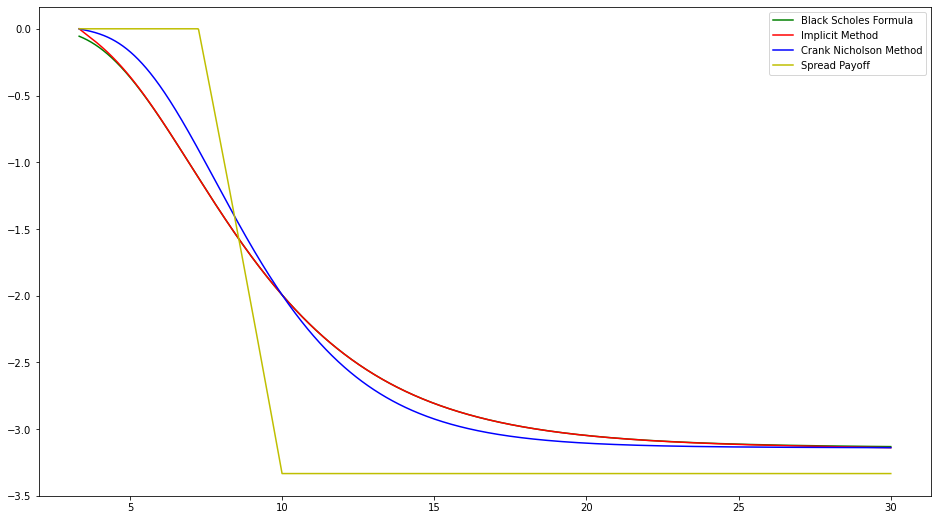

In [146]:
nb_x = 2 * nb_x_side + 1
xs = np.linspace(np.log(S_0)-H, np.log(S_0)+H, nb_x)

plt.plot(np.exp(xs),BS_formula_call(np.exp(xs),K1, r, sigma, T)-BS_formula_call(np.exp(xs),K2, r, sigma, T),'g', label = 'Black Scholes Formula')
plt.plot(np.exp(xs), t1[:,-1]-t2[:,-1],'r', label = 'Implicit Method')
plt.plot(np.exp(xs), t_cn[:,-1],'b', label = "Crank Nicholson Method")
plt.plot(np.exp(xs), t_cn[:,0],'y', label ='Spread Payoff')
plt.legend()
plt.show()

To price a put the following boundary conditions were used:


$Terminal:    V(T,x) = max(K-e^x,0)$
 
$Lateral:    V(t, x) \underset{x \to -\infty}{\sim} Ke^{-r(T-t)} \quad \mbox{and} \quad V(t, x) \underset{x \to \infty}{=} 0. $
   
Similar to the call, instead of considering that x goes to infinity, H is defined sufficiently large such that the bounds for the dx variation is [log(S0) − H ,log(S0) + H]

The implicit and the crank nicholson method for the put is the same, only the boundary conditions is changed and the conditions needed to solve the matrix form of the related equations are changed as shown in the code below:

In [147]:
def pde_scheme_implicit_put(S_0, r, sigma, T, K, H, nb_x_side, nb_t):
    nb_x = 2 * nb_x_side + 1
    xs = np.linspace(np.log(S_0)-H, np.log(S_0)+H, nb_x)
    dx = 2. * H / (nb_x - 1.) 
    dt = T / (nb_t - 1.)
    ts = np.linspace(0, T, nb_t)
    p = np.empty([nb_x, nb_t])
    g = lambda S : np.maximum(K-S,0.)
    p[:,0] = g(np.exp(xs)) 
    p[0,:] = K * np.exp(-r*ts) - np.exp(np.log(S_0)-H)
    p[-1,:] =  0.
    d = 1.+dt*(r + (r-0.5*sigma**2)/dx + sigma**2 / dx**2)
    sup_d = -dt*((r-0.5*sigma**2)/dx + 0.5 * sigma**2 / dx**2)
    inf_d = -dt*(0.5 * sigma**2 / dx**2)
    A = np.diag(d * np.ones(nb_x-2)) + np.diag(sup_d * np.ones(nb_x-3), 1) + np.diag(inf_d * np.ones(nb_x-3), -1)
    v = np.zeros_like(p[1:-1,0])
    v[0] = 1.
    invA = np.linalg.inv(A)
    for t in range(1,nb_t):
        p[1:-1,t] = invA @ (p[1:-1,t-1] - inf_d * p[0,t] * v)   
    return p,p[nb_x_side,-1]


In [148]:
S_0 = 10
r = 0.02
sigma = 0.25
K = .8*S_0
T = 10
H = np.log(3)
nb_x_side = 500
nb_t = 10000
put_imp,put_imp_price = pde_scheme_implicit_put(S_0, r, sigma, T, K, H, nb_x_side, nb_t)
put_price


1.135419044838481

In [149]:
def pde_scheme_crank_nicholson_put(S_0, r, sigma, T, K, H, nb_x_side, nb_t):
    nb_x = 2 * nb_x_side + 1
    xs = np.linspace(np.log(S_0)-H, np.log(S_0)+H, nb_x)
    dx = 2. * H / (nb_x - 1.) 
    dt = T / (nb_t - 1.)
    ts = np.linspace(0, T, nb_t)
    p = np.empty([nb_x, nb_t])
    g = lambda S : np.maximum(K-S,0.)
    p[:,0] = g(np.exp(xs)) 
    p[0,:] = K * np.exp(-r*ts) - np.exp(np.log(S_0)-H)
    p[-1,:] =  0.
    alpha = 0.25*(dt/dx)*(r-(0.5*sigma**2)-(sigma**2/dx))
    beta = dt*0.5*(r+(sigma**2)/dx**2)
    gamma = 0.25*(dt/dx)*((0.5*sigma**2)-r-(sigma**2/dx))
    M1 = np.diag((1+beta)*np.ones(nb_x-2))+np.diag(gamma*np.ones(nb_x-3),1) + np.diag(alpha*np.ones(nb_x-3),-1)
    M2  = np.diag((1-beta)*np.ones(nb_x-2))+np.diag(-gamma*np.ones(nb_x-3),1) + np.diag(-alpha*np.ones(nb_x-3),-1)
    v = np.zeros_like(p[1:-1,0])
    v[0] = 1.
    invM1 = np.linalg.inv(M1)
    for t in range(1,nb_t):
        p[1:-1,t] = invM1 @ ((M2@p[1:-1,t-1]) - (alpha * p[0,t] * v) +  (-alpha * p[0,t] * v))
    return p,p[nb_x_side,-1]


In [150]:
def BS_formula_put(S_0, K, r, sigma, T):
    d_1 = (np.log(S_0/K) + (r + sigma**2/2) * T)/(sigma * np.sqrt(T))
    d_2 = d_1 - sigma * np.sqrt(T)
    return -S_0 * norm.cdf(-d_1) + K * np.exp(-r*T) * norm.cdf(-d_2)


In [151]:
put_bs = BS_formula_put(S_0, K, r, sigma, T)
put_bs

1.149911346784067

In [152]:
put_cn,put_cn_price=pde_scheme_crank_nicholson_put(S_0, r, sigma, T, K, H, nb_x_side, nb_t)



In [153]:
print("PUT Prices for 80% Moneyness \n")
print("Implicit method  : %f" %put_imp_price)
print("Crank Nicholson method  : %f"%put_cn_price)
print("Black Scholes formula price : %f" %put_bs )

PUT Prices for 80% Moneyness 

Implicit method  : 1.135419
Crank Nicholson method  : 1.135637
Black Scholes formula price : 1.149911


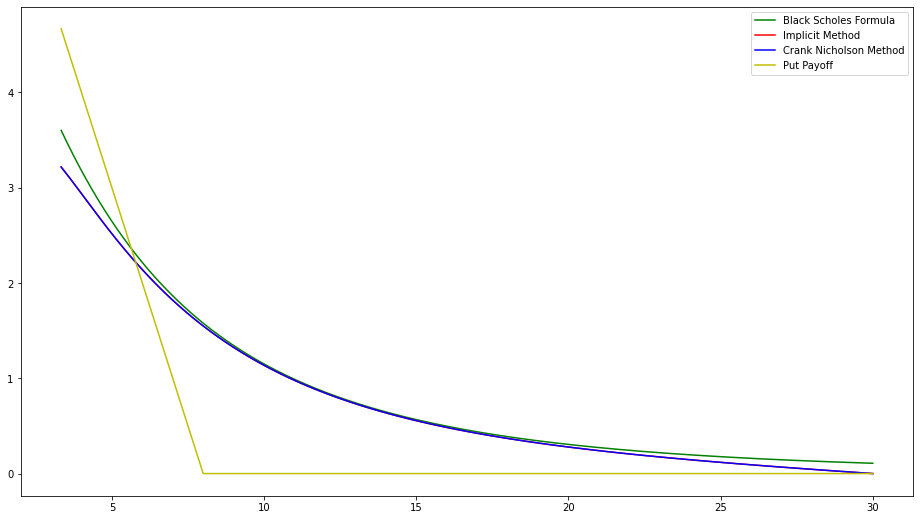

In [154]:
nb_x = 2 * nb_x_side + 1
xs = np.linspace(np.log(S_0)-H, np.log(S_0)+H, nb_x)

plt.plot(np.exp(xs),BS_formula_put(np.exp(xs),K, r, sigma, T),'g',label = 'Black Scholes Formula')
plt.plot(np.exp(xs), put_imp[:,-1],'r', label = 'Implicit Method')
plt.plot(np.exp(xs), put_cn[:,-1],'b',label = 'Crank Nicholson Method')
plt.plot(np.exp(xs), put_imp[:,0],'y', label = "Put Payoff")
plt.legend()
plt.show()


#one can look carefully to see the overlapping of red and blue curves